<a href="https://colab.research.google.com/github/ariesslin/ie7500-g1-tweet-sentiment-nlp/blob/main/scripts/2.%20Data%20Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="background-color:#e6f2ff; border-left:8px solid #0059b3; padding:20px; margin:20px 0;">
  <h2 style="color:#003366;"><strong>2. Data Preprocessing</strong></h2>
  <p style="color:#333333;">Preparing data for model training and testing</p>
</div>

Raw tweet data is often noisy, inconsistent, and full of informal elements like emojis, mentions, hashtags, abbreviations, and inconsistent casing. Cleaning and standardizing this data is a critical step before any meaningful modeling can be done. Effective preprocessing not only improves model performance but also ensures that the insights learned from the data are robust and generalizable.

In this notebook, we apply a series of preprocessing steps tailored specifically to Twitter data, with the goal of simplifying the input while preserving sentiment-relevant patterns. The following steps will be applied to the Sentiment140 dataset:

- **Lowercasing** – Convert all text to lowercase to ensure consistency and reduce redundant token forms (e.g., "Happy" vs. "happy").
- **Email Removal** – Remove email addresses (e.g., `user@example.com`) as they typically do not contribute to sentiment and may introduce noise or privacy concerns.
- **Mention, Hashtag & URL, HTML tags Handling** – Replace Twitter mentions (e.g., @username) with a generic token (`usermention`), remove URLs that typically do not contribute to sentiment, and normalize hashtags (e.g., `#happy` → `happy`), and remove HTML tags (e.g., `<b>great</b>`) to ensure clean, readable text.
- **Number and Whitespace Cleanup** – After token processing, remove excess spaces and strip leading/trailing whitespace.
- **Punctuation & Special Character Removal** – Remove common punctuation marks and special characters to simplify the token vocabulary and reduce noise.
- **Tokenization** – Split each tweet into a list of word tokens for structured processing in downstream models.
- **Lemmatization** – Reduce words to their dictionary (base) form to unify variations and decrease vocabulary size (e.g., "running" → "run").
- **Stopword Removal** – Filter out common stopwords (e.g., "and", "is") that carry little semantic weight, using an extended list that includes punctuation.
- **Empty Tweet Filtering** – Drop tweets that are empty after preprocessing to ensure that all inputs to the model are meaningful.

These steps help remove noise while preserving semantic structure, which is especially important for models like LSTM and BERT that are sensitive to input tokenization.

Finally, we will **split the dataset into training, validation and testing subsets** to evaluate the models' generalization performance on unseen data.

This preprocessing pipeline prepares our dataset for vectorization and embedding, enabling classical models like Logistic Regression as well as deep learning architectures to learn from tweet text effectively.

<div style="background-color:#e6f2ff; border-left:8px solid #0059b3; padding:20px; margin:20px 0;">
  <h2 style="color:#003366;"><strong>1. Data Loading & EDA Filter Apply</strong></h2>
  <p style="color:#333333;">Import Sentiment140 dataset and preprocess it with steps we already did during EDA.</p>
</div>

In [1]:
# Importing all libraries here
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TreebankWordTokenizer, word_tokenize
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import seaborn as sns
import spacy
import string
import sys
import os

In [2]:
# Import helper functions modularized from our EDA notebook
sys.path.append("../utils")
from helper import load_sentiment140, preprocess_raw_text_in_eda

In [3]:
# Step 1: Load Sentiment140 dataframe
df = load_sentiment140()

# Step 2: Preprocess raw text (decode, unescape HTML characters, remove empty rows, add length)
df = preprocess_raw_text_in_eda(df)

In [4]:
# Count how many tweets are longer than 140 characters
num_long_tweets = df[df['text_length'] > 140].shape[0]
print(f"Number of tweets longer than 140 characters: {num_long_tweets}")

Number of tweets longer than 140 characters: 0


In [5]:
# Disable truncation in display
pd.set_option('display.max_colwidth', None)

# Sort by tweet length and show the top 10 longest tweets
df.sort_values(by='text_length', ascending=False)[['text', 'text_length']].head(10)

,text,text_length
1462693,"i am NOT liking the ""big-curly-hair-with-the-braids"" look :/ im not taking my braids out! i will just simply straighten my hair once more",138
1402277,Woke up to a storm outside...Florida gets on my nerves sometimes...the state not the lady from Good Times...except the episode when...nvm,138
1307540,"@ohmishka I thought it was such a great idea too, she said she would rather support independent artists than give her $ to big companies.",138
805844,"I like penis: Ok so backup only was not enough for you pussys, HERE, have some credit cards too You know, it'.. http://tinyurl.com/d356b3",138
805840,"Selling DILDO in a box: Ok so backup only was not enough for you pussys, HERE, have some credit cards too You.. http://tinyurl.com/ca2ecn",138
1111822,"http://twiturm.com/vew6 I made this mix just for fun. I used to live w/ 1 of the BCR (not as a bf) though in Lake Forest, CA. Trying ...",138
975039,"@chiropractic ha! you are my hero. weekend stats looking good over here, lots of people dreading their job come monday, searching 4 new 1",138
252190,Is finally back from London after being stuck in traffic for about 5 hours! I now have hardly any time to get work done. Long night ahead,138
626735,@brennygee Looks like the twitterverse disagrees with you I just figured my first iPod was white- I thought I'd be kicking it old school.,138
1307506,"yup its going to be @TaqiyyaLuvLa @10marion @officialTila @Tyrese4Real @Willie_Day26 @souljaboytellem and many more tonight,fun... lol jk",138


In [6]:
pd.reset_option('display.max_colwidth')

#### Data Loading and First Step Preprocessing Summary

From the above result, we confirm that the Sentiment140 dataset has been **successfully loaded and preprocessed** using the same steps developed during the EDA phase. 

<div style="background-color:#e6f2ff; border-left:8px solid #0059b3; padding:20px; margin:20px 0;">
  <h2 style="color:#003366;"><strong>2. Data Preprocessing</strong></h2>
  <p style="color:#333333;">Steps: lowercasing, punctuation & stopword removal, tokenization, stemming, lemmatization, cleaning hashtags, mentions, URLs, numbers.</p>
</div>

In [7]:
# Download the stopwords, punkt and wordnet
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ariesslin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ariesslin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ariesslin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/ariesslin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [8]:
#!python -m spacy download en_core_web_lg

try:
    nlp = spacy.load("en_core_web_lg")
except OSError:
    # Only download if the model is not already installed
    from spacy.cli import download
    download("en_core_web_lg")
    nlp = spacy.load("en_core_web_lg")

In [9]:
# Load NLP model (includes word vectors and lemmatizer)
nlp = spacy.load('en_core_web_lg')

### Lowercasing

We lowercase all text to reduce redundancy — for example, "Happy" and "happy" should be treated the same. This standardization helps models treat words as case-insensitive unless case carries specific meaning (which it usually doesn't in tweets).

In [10]:
# Create a clean copy of relevant columns
tweets = df.loc[:, ['text', 'target']].copy()

# Apply lowercase
tweets['text'] = tweets['text'].str.lower()
tweets.head()

,text,target
0,"@switchfoot http://twitpic.com/2y1zl - awww, t...",0
1,is upset that he can't update his facebook by ...,0
2,@kenichan i dived many times for the ball. man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


### Email Removal

Email addresses (e.g., "user@example.com") are not relevant to tweet sentiment and may represent spam or personal identifiers. We remove them using regex to clean the text and avoid introducing unnecessary tokens or bias into the model.

In [11]:
# Match regex to remove emails
tweets['text'] = tweets['text'].apply(lambda x: re.sub(r'\S+@\S+\.\S+', '', str(x)))

tweets.head()

,text,target
0,"@switchfoot http://twitpic.com/2y1zl - awww, t...",0
1,is upset that he can't update his facebook by ...,0
2,@kenichan i dived many times for the ball. man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


### Mentions, Hashtags, URLs, and HTML Tag Handling

We replace Twitter mentions (e.g., `@elonmusk`) with a generic token (`usermention`), remove URLs which typically do not carry sentiment information and introduce noise, strip hashtags (e.g., `#happy` → `happy`) so that keywords remain usable for modeling, and remove HTML tags (e.g., `<b>great</b>`) to ensure clean, readable input. This step helps clean the data while preserving tweet structure and retaining emotionally relevant content.

In [12]:
# Replace all @mentions with "usermention"
tweets['text'] = tweets['text'].str.replace(r'@\w+', 'usermention ', regex=True)

# Remove '#' from hashtags but keep the word
tweets['text'] = tweets['text'].str.replace(r'#', '', regex=True)

# Remove URLs
tweets['text'] = tweets['text'].str.replace(r'http\S+|www\S+|https\S+', '', regex=True)

# Remove html tags
tweets['text'] = tweets['text'].str.replace(r'<.*?>', '', regex=True)

tweets.head()

,text,target
0,usermention - a that's a bummer. you should...,0
1,is upset that he can't update his facebook by ...,0
2,usermention i dived many times for the ball. ...,0
3,my whole body feels itchy and like its on fire,0
4,"usermention no, it's not behaving at all. i'm...",0


#### Why We Keep the 'usermention' Token

Instead of removing user mentions entirely (e.g., `@elonmusk`), we replace them with a generic placeholder token: `usermention`. This preserves the fact that the tweet is directed at someone, which can carry important sentiment signals.

For example:
- `"usermention you are amazing!"` likely expresses positive sentiment toward someone
- `"usermention this is terrible"` may reflect negative sentiment or a complaint

By standardizing all mentions to a single token:
- We remove identity-specific noise (e.g., usernames)
- We retain structural and emotional intent, especially useful for models like **Logistic Regression**, **LSTM**, and **BERT**, which can learn patterns involving direct address

This token helps the model distinguish between general statements and targeted expressions — often a subtle but meaningful difference in sentiment classification.

### Number and Whitespace Cleanup

We remove numeric digits from tweets to prevent potential noise from irrelevant numbers (e.g., user IDs, dates, counts). Then we normalize whitespace by converting multiple consecutive spaces into a single space and trimming leading/trailing whitespace. This ensures clean, consistent input formatting for the model.

In [13]:
def clean_numbers_and_whitespace(text):
    # Remove digits
    text = ''.join(char for char in text if not char.isdigit())
    # Normalize whitespace
    return ' '.join(text.split())

tweets['text'] = tweets['text'].apply(clean_numbers_and_whitespace)

tweets.head()

,text,target
0,usermention - a that's a bummer. you shoulda g...,0
1,is upset that he can't update his facebook by ...,0
2,usermention i dived many times for the ball. m...,0
3,my whole body feels itchy and like its on fire,0
4,"usermention no, it's not behaving at all. i'm ...",0


### Punctuation & Special Character Removal

We remove standard punctuation symbols (e.g., `.`, `,`, `!`, `?`) to reduce vocabulary noise and standardize tokens. This step helps models focus on the core semantic content of tweets rather than stylistic or formatting variations.

In [14]:
punctuation_pattern = r'[{}]'.format(re.escape(string.punctuation))

# Remove punctuation
tweets['text'] = tweets['text'].str.replace(punctuation_pattern, '', regex=True)

# Remove special characters (keep only letters, digits, and whitespace)
tweets['text'] = tweets['text'].str.replace(r'[^\w\s]', '', regex=True)

tweets.head()

,text,target
0,usermention a thats a bummer you shoulda got ...,0
1,is upset that he cant update his facebook by t...,0
2,usermention i dived many times for the ball ma...,0
3,my whole body feels itchy and like its on fire,0
4,usermention no its not behaving at all im mad ...,0


### Tokenization

Before removing stopwords, we tokenize each tweet into individual words. This allows us to filter out unwanted tokens and prepare the data for model ingestion. We use `nltk.word_tokenize()` for consistent, linguistically aware token boundaries.

In [15]:
tokenizer = TreebankWordTokenizer()

# Tokenize tweets
tweets['tokens'] = tweets['text'].apply(tokenizer.tokenize)

tweets.head()

,text,target,tokens
0,usermention a thats a bummer you shoulda got ...,0,"[usermention, a, thats, a, bummer, you, should..."
1,is upset that he cant update his facebook by t...,0,"[is, upset, that, he, cant, update, his, faceb..."
2,usermention i dived many times for the ball ma...,0,"[usermention, i, dived, many, times, for, the,..."
3,my whole body feels itchy and like its on fire,0,"[my, whole, body, feels, itchy, and, like, its..."
4,usermention no its not behaving at all im mad ...,0,"[usermention, no, its, not, behaving, at, all,..."


### Lemmatization

Lemmatization converts each word to its base form — e.g., "running" → "run". This reduces the total number of unique tokens and helps models generalize across word variations without losing semantic meaning.

In [16]:
# Lemmatizers
lemmatizer = WordNetLemmatizer()

# WordNetLemmatizer defaults to noun if we don’t tell it the POS tag
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # fallback

# Lemmatize each token except 'usermention'
def lemmatize_tokens(tokens):
    tagged = pos_tag(tokens)
    return [
        lemmatizer.lemmatize(word, get_wordnet_pos(tag)) if word != 'usermention' else word
        for word, tag in tagged
    ]

# Apply to the 'tokens' column
tweets['tokens'] = tweets['tokens'].apply(lemmatize_tokens)

# Rejoin back into cleaned text
tweets['text'] = tweets['tokens'].apply(lambda x: ' '.join(x))

tweets.head()

,text,target,tokens
0,usermention a thats a bummer you shoulda get d...,0,"[usermention, a, thats, a, bummer, you, should..."
1,be upset that he cant update his facebook by t...,0,"[be, upset, that, he, cant, update, his, faceb..."
2,usermention i dive many time for the ball mana...,0,"[usermention, i, dive, many, time, for, the, b..."
3,my whole body feel itchy and like it on fire,0,"[my, whole, body, feel, itchy, and, like, it, ..."
4,usermention no it not behave at all im mad why...,0,"[usermention, no, it, not, behave, at, all, im..."


#### Why We Use Lemmatization Instead of Stemming

Although stemming (e.g., using `PorterStemmer`) is a common text preprocessing step, we chose **lemmatization** here because it retains more accurate and interpretable base forms of words. For example, lemmatization correctly maps:

- "running" → "run"
- "better" → "good"

Whereas stemming would incorrectly output:

- "running" → "run"
- "better" → "bett"

This distinction is important for our models:

- **Logistic Regression (TF-IDF)**: Lemmatization improves generalization while preserving word meaning.
- **LSTM**: Sequence models benefit from accurate word forms to capture semantic structure.
- **BERT**: Already handles word variations internally (via subword tokenization), but providing cleaner input can still help.

Thus, lemmatization is the better choice for our pipeline, and stemming was deliberately excluded.

### Stopword Removal

Stopwords are very common words (like "the", "and", "is") that generally carry little semantic meaning in text classification. Removing them helps focus on words with stronger sentiment signal. We apply this step using a vectorized approach across all tweets to improve efficiency. The stopword list is extended to also remove punctuation and common social media symbols.

In [17]:
stop_words = set(stopwords.words('english'))

# Add extra symbols to stop words
stop_words.update(string.punctuation)
stop_words.update(["''", "'", '``', '’', '“', '”','–', '—', '…', '..', '.', ',', ':', ';', '?', '!', '(', ')', '[', ']', '{', '}', '/', '|'])

In [18]:
# Remove stopwords but keep 'usermention'
tweets['tokens'] = tweets['tokens'].apply(
    lambda tokens: [word for word in tokens if word.lower() not in stop_words or word == 'usermention']
)

# Rejoin tokens to text for downstream models
tweets['text'] = tweets['tokens'].apply(lambda x: ' '.join(x))

tweets.head()

,text,target,tokens
0,usermention thats bummer shoulda get david car...,0,"[usermention, thats, bummer, shoulda, get, dav..."
1,upset cant update facebook texting might cry r...,0,"[upset, cant, update, facebook, texting, might..."
2,usermention dive many time ball manage save re...,0,"[usermention, dive, many, time, ball, manage, ..."
3,whole body feel itchy like fire,0,"[whole, body, feel, itchy, like, fire]"
4,usermention behave im mad cant see,0,"[usermention, behave, im, mad, cant, see]"


#### Why We Extend the Stopword List with Punctuation and Special Symbols

Although we remove most punctuation at the raw text level using string replacement, some unwanted characters and symbols can still survive into the tokenized text. This is especially true for:

- Unicode punctuation (e.g., smart quotes `“ ”`, apostrophes `’`, ellipses `…`)
- Duplicate or broken punctuation (e.g., `..`, `...`)
- Special characters not included in `string.punctuation` (e.g., `{}`, `[]`, `|`)
- Symbols that may be split as tokens by the tokenizer (e.g., `(`, `)`, `/`, `|`)

To ensure we clean these up consistently, we **extend the stopword list** with both:
- The built-in `string.punctuation`, and
- A custom list of additional noisy tokens that frequently appear in tweets

This helps reduce vocabulary noise, avoid irrelevant tokens in our models, and ensures that even after tokenization, our data remains clean and focused on meaningful words.

### Empty Tweet Filtering

After preprocessing (e.g., tokenization, lemmatization, and stopword removal), some tweets may become completely empty — especially if they originally consisted only of links, mentions, or stop words. These empty entries carry no useful signal for the model and can lead to runtime issues or introduce noise. We filter out any tweets that are null or blank after cleaning to ensure that all samples passed to modeling are meaningful and valid.

In [19]:
tweets['text'].apply(lambda x: pd.isna(x) or str(x).strip() == '').sum()

542

In [20]:
# Remove rows where the text is missing or just empty
tweets = tweets[
    tweets['text'].notna() & (tweets['text'].str.strip() != '')
]

tweets['text'].apply(lambda x: pd.isna(x) or str(x).strip() == '').sum()

0

In [21]:
# Take only columns with features and labels
preprocessed_tweets = tweets.loc[:, ['text', 'target']].copy()
preprocessed_tweets.head()

,text,target
0,usermention thats bummer shoulda get david car...,0
1,upset cant update facebook texting might cry r...,0
2,usermention dive many time ball manage save re...,0
3,whole body feel itchy like fire,0
4,usermention behave im mad cant see,0


### Visualizing Word Frequencies by Sentiment with Word Clouds

To gain a qualitative understanding of the most common words in positive and negative tweets, we generate word clouds for each sentiment class. Word clouds provide an intuitive visual representation where the size of each word corresponds to its frequency in the corpus.

These visualizations help highlight patterns and dominant terms associated with different sentiments. For example, negative tweets might emphasize complaints, frustration, or issues, whereas positive tweets often contain words of praise, excitement, or joy.

Below, we generate separate word clouds for:
- **Negative Tweets (label = 0)** using a red color palette
- **Positive Tweets (label = 4)** using a green color palette

This allows us to quickly compare the linguistic tendencies across sentiment classes and verify if high-frequency terms align with intuitive emotional cues.


In [22]:
def generate_word_cloud(text_series, sentiment_label, color_map, title):
    """
    Generate and display a word cloud for a given set of tweets.

    Parameters:
    - text_series: pd.Series containing tweet text
    - sentiment_label: sentiment class (0 for negative, 4 for positive)
    - color_map: colormap to use for the word cloud
    - title: title of the plot
    """
    # Combine all tweet text into a single string
    text_blob = ' '.join(text_series.astype(str))

    # Generate word cloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap=color_map,
        max_words=200
    ).generate(text_blob)

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=16, fontweight='bold')
    plt.show()

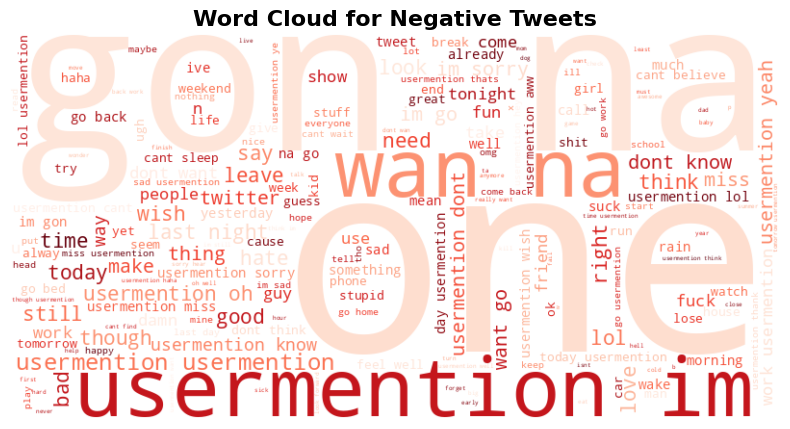

In [23]:
# Negative Tweets word cloud

# Filter only negative tweets (target == 0)
negative_tweets = preprocessed_tweets[preprocessed_tweets['target'] == 0]['text']
generate_word_cloud(negative_tweets, sentiment_label=0, color_map='Reds', title="Word Cloud for Negative Tweets")

#### Observations from Negative Tweets Word Cloud

Contrary to common expectations, the word cloud for negative tweets does **not prominently feature overtly negative sentiment words** (e.g., "hate", "angry", "terrible"). Instead, we observe:

- High-frequency usage of casual or neutral terms such as **“gonna”**, **“one”**, **“today”**, **“still”**, and **“look”**
- Frequent appearance of platform-specific terms like **"usermention"**, suggesting conversational or reply-driven tweets
- A mix of emotionally ambiguous verbs (e.g., **“want”**, **“leave”**, **“miss”**, **“think”**) that may imply context-dependent negativity

This suggests that:
- Negative sentiment in tweets is often **subtle, implied, or context-driven**
- Word clouds alone may not capture nuanced emotional tone, highlighting the need for **token-level analysis or embedding-based methods** in modeling

The word cloud still offers a useful glimpse into **frequent vocabulary**, but must be interpreted cautiously in sentiment classification tasks.

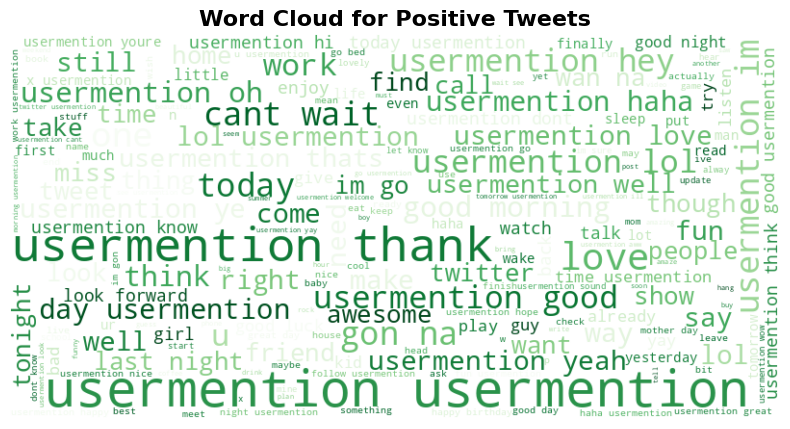

In [24]:
# Positive Tweets word cloud

# Filter only positive tweets (target == 4)
positive_tweets = preprocessed_tweets[preprocessed_tweets['target'] == 4]['text']
generate_word_cloud(positive_tweets, sentiment_label=4, color_map='Greens', title="Word Cloud for Positive Tweets")

#### Observations from Positive Tweets Word Cloud

The word cloud for positive tweets contains several emotionally expressive and sentiment-rich terms:

- Common expressions of **positivity and enthusiasm** include:  
  **“love”**, **“thank”**, **“fun”**, **“good”**, **“awesome”**, and **“yay”**
  
- Social and conversational terms such as **“usermention”**, **“yeah”**, **“hey”**, and **“lol”** suggest frequent friendly or appreciative interactions

- Phrases like **“cant wait”**, **“good morning”**, **“enjoy”**, and **“watch”** point to anticipation and excitement, reinforcing the emotional tone

Overall, the positive tweets show a **higher lexical alignment with positive sentiment**, making the contrast with negative tweets visually and semantically evident. This supports the effectiveness of the sentiment labels and validates the dataset for downstream modeling.

### Verify Target Distribution Balance After Preprocessing

To validate that our preprocessing pipeline has preserved the integrity of the dataset, we now visualize the distribution of sentiment labels (`target`) in the cleaned data.

This step serves two main purposes:

1. **Consistency Check**: We compare this distribution to the original one observed during EDA to ensure that no unintended filtering or transformation has skewed the balance between positive and negative tweets.

2. **Baseline for Downstream Splits**: This gives us a reference before we apply stratified splitting, ensuring that we begin from a well-balanced dataset.

A roughly even class distribution — as observed in the original dataset — is important for fair model training and evaluation.

In [25]:
# Define sentiment color palette
sentiment_palette = {
    0: '#fc8d62',  # Negative sentiment
    4: '#66c2a5'   # Positive sentiment
}

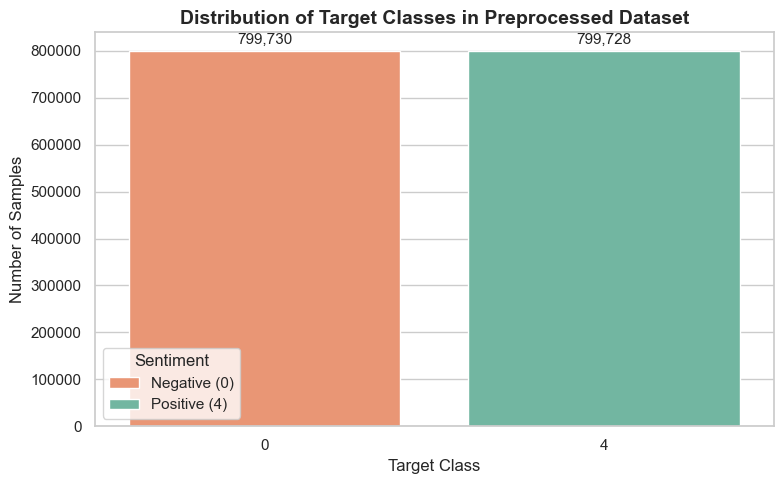

In [26]:
# we now start visualizing the distributions of the target

# Set a clean visual style
sns.set(style="whitegrid")

# Calculate value counts
target_counts = preprocessed_tweets['target'].value_counts().sort_index()

# Create the bar plot
plt.figure(figsize=(8, 5))
barplot = sns.barplot(x=target_counts.index, y=target_counts.values, hue=target_counts.index, palette=sentiment_palette, legend=True)

# Add value labels on bars
for i, value in enumerate(target_counts.values):
    plt.text(i, value + max(target_counts.values)*0.01, f'{value:,}',
             ha='center', va='bottom', fontsize=11)

# Titles and labels
plt.title('Distribution of Target Classes in Preprocessed Dataset', fontsize=14, fontweight='bold')
plt.xlabel('Target Class', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()

# Customize the legend labels
# Get the legend object
handles, labels = barplot.get_legend_handles_labels()

# Create a dictionary to map old labels (0, 4) to new labels ('Negative', 'Positive')
new_labels = {'0': 'Negative (0)', '4': 'Positive (4)'}

# Update the labels in the legend
updated_labels = [new_labels[label] for label in labels]
barplot.legend(handles, updated_labels, title="Sentiment")

plt.show()

#### Observation: Sentiment Class Balance

The target distribution remains nearly perfectly balanced between negative (`0`) and positive (`4`) tweets after preprocessing.

This confirms that the data integrity is preserved and we can proceed confidently to the stratified splitting step.

### Saving the Preprocessed Dataset

After completing all preprocessing steps, we save the cleaned and tokenized tweet data to a CSV file. This ensures consistency across model development and allows all team members to use the same standardized input without rerunning the preprocessing pipeline.

In [27]:
# We now save the processed tweets to be used later in model development

processed_data_dir = "../processed_data"
os.makedirs(processed_data_dir, exist_ok=True)

output_processed_file_path = os.path.join(processed_data_dir, "preprocessed_tweets.csv")
preprocessed_tweets.to_csv(output_processed_file_path, index=False)

print(f"Preprocessed tweets saved to: {output_processed_file_path}")

Preprocessed tweets saved to: ../processed_data/preprocessed_tweets.csv


<div style="background-color:#e6f2ff; border-left:8px solid #0059b3; padding:20px; margin:20px 0;">
  <h2 style="color:#003366;"><strong>3. Dataset Splitting & Stratification</strong></h2>
  <p style="color:#333333;">To ensure fair model training and evaluation, we split the preprocessed dataset into training (70%), validation (15%), and testing (15%) sets.
    This is done using a stratified approach that maintains both sentiment label balance and tweet length distribution.</p>
</div>

### Why 70/15/15 Split for Train, Validation, and Test?

We split the dataset into 70% training, 15% validation, and 15% testing to ensure that:

- **Training (70%)**: Provides enough data for the models to learn robust patterns.
- **Validation (15%)**: Enables effective model selection and hyperparameter tuning without leaking test information.
- **Testing (15%)**: Offers a fair and unbiased evaluation of final model performance on unseen data.

This common split ratio balances the need for learning and generalization, especially when working with large-scale datasets like Sentiment140. By combining this with stratified sampling (by sentiment and length), we ensure consistency and fairness across model evaluation.

### Stratified Splitting by Length Buckets

In addition to maintaining a balanced distribution of sentiment labels (positive vs. negative), we also apply **length-aware stratification** to ensure our train, validation, and test sets are representative in terms of tweet length.

#### Why This Matters
Tweet length can significantly impact model behavior:
- Short tweets may contain slang, abbreviations, or lack clear context.
- Longer tweets may carry more sentiment cues or syntactic structure.
- If the data splits are biased toward different length profiles, models may struggle to generalize.

To mitigate this, we:
1. **Assign tweets to discrete length buckets** based on character count (e.g., short, medium, long).
2. **Stratify splits** using both sentiment label and length bucket.

This results in train, validation, and test sets that are **balanced not only in sentiment**, but also in **text length distribution**, improving fairness and model robustness across varying input lengths.

### Implementing Stratified Splitting by Tweet Length

In the following, we implement a stratified splitting strategy that preserves the distribution of both sentiment labels and tweet lengths across the training, validation, and test sets.

To do this:
1. We define **length buckets** based on tweet character counts (e.g., short, medium, long).
2. We perform **stratified sampling** within each sentiment class (positive, negative) based on these length buckets.
3. We then **combine** and **shuffle** the splits to form the final datasets.

This ensures that all splits are both sentiment-balanced and length-representative, which helps prevent model bias toward certain tweet lengths.

In [28]:
# Define dataset split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Define bins and labels from the bar chart in our EDA
bin_edges = [0, 20, 40, 60, 80, 100, 120, 140]
bin_labels = ['0–20', '21–40', '41–60', '61–80', '81–100', '101–120', '121–140']

# Step 1: Assign length buckets safely
def assign_length_buckets(df):
    df = df.copy()
    df['text'] = df['text'].fillna('').astype(str)  # Ensure no NaNs
    df['text_length'] = df['text'].str.len()
    df['length_bucket'] = pd.cut(
        df['text_length'],
        bins=bin_edges,
        labels=bin_labels,
        right=True,
        include_lowest=True
    )
    df = df.dropna(subset=['length_bucket'])  # Drop any that didn't fall in bin
    return df

# Step 2: Stratified split function
def stratified_split_by_length_bucket(df_class, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    df_class = assign_length_buckets(df_class)

    # Split into train and temp
    train_df, temp_df = train_test_split(
        df_class,
        test_size=1 - train_ratio,
        stratify=df_class['length_bucket'],
        random_state=42
    )

    # Split temp into validation and test
    val_ratio_adjusted = val_ratio / (val_ratio + test_ratio)
    val_df, test_df = train_test_split(
        temp_df,
        test_size=1 - val_ratio_adjusted,
        stratify=temp_df['length_bucket'],
        random_state=42
    )

    return train_df.drop(columns='length_bucket'), val_df.drop(columns='length_bucket'), test_df.drop(columns='length_bucket')

# Step 3: Filter by sentiment
df_neg = preprocessed_tweets[preprocessed_tweets['target'] == 0]
df_pos = preprocessed_tweets[preprocessed_tweets['target'] == 4]

# Step 4: Apply stratified splitting
neg_train, neg_val, neg_test = stratified_split_by_length_bucket(df_neg, train_ratio, val_ratio, test_ratio)
pos_train, pos_val, pos_test = stratified_split_by_length_bucket(df_pos, train_ratio, val_ratio, test_ratio)

# Step 5: Combine and shuffle
train_df = pd.concat([neg_train, pos_train]).sample(frac=1, random_state=42).reset_index(drop=True)
val_df = pd.concat([neg_val, pos_val]).sample(frac=1, random_state=42).reset_index(drop=True)
test_df = pd.concat([neg_test, pos_test]).sample(frac=1, random_state=42).reset_index(drop=True)

# Step 6: Extract input and labels
X_train = train_df['text']
y_train = train_df['target']
X_val = val_df['text']
y_val = val_df['target']
X_test = test_df['text']
y_test = test_df['target']

# Final check
print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("Test shape:", test_df.shape)
print("X_train shape:", X_train.shape, "| y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape, "| y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape, "| y_test shape:", y_test.shape)

Train shape: (1119609, 3)
Validation shape: (239917, 3)
Test shape: (239917, 3)
X_train shape: (1119609,) | y_train shape: (1119609,)
X_val shape: (239917,) | y_val shape: (239917,)
X_test shape: (239917,) | y_test shape: (239917,)


#### Split Verification Summary

The final shapes of the training, validation, and test sets confirm a correct 70/15/15 split. Since we stratified by both sentiment and tweet length, each subset reflects the diversity of the original dataset.

### Verifying Distribution Consistency Across Splits

To ensure that our train, validation, and test sets remain representative, we visualize the distribution of tweet lengths for each sentiment label across the three splits.

By using violin plots, we can visually compare both the central tendencies and the spread of tweet lengths across the splits — providing confidence in the integrity of our stratified sampling.

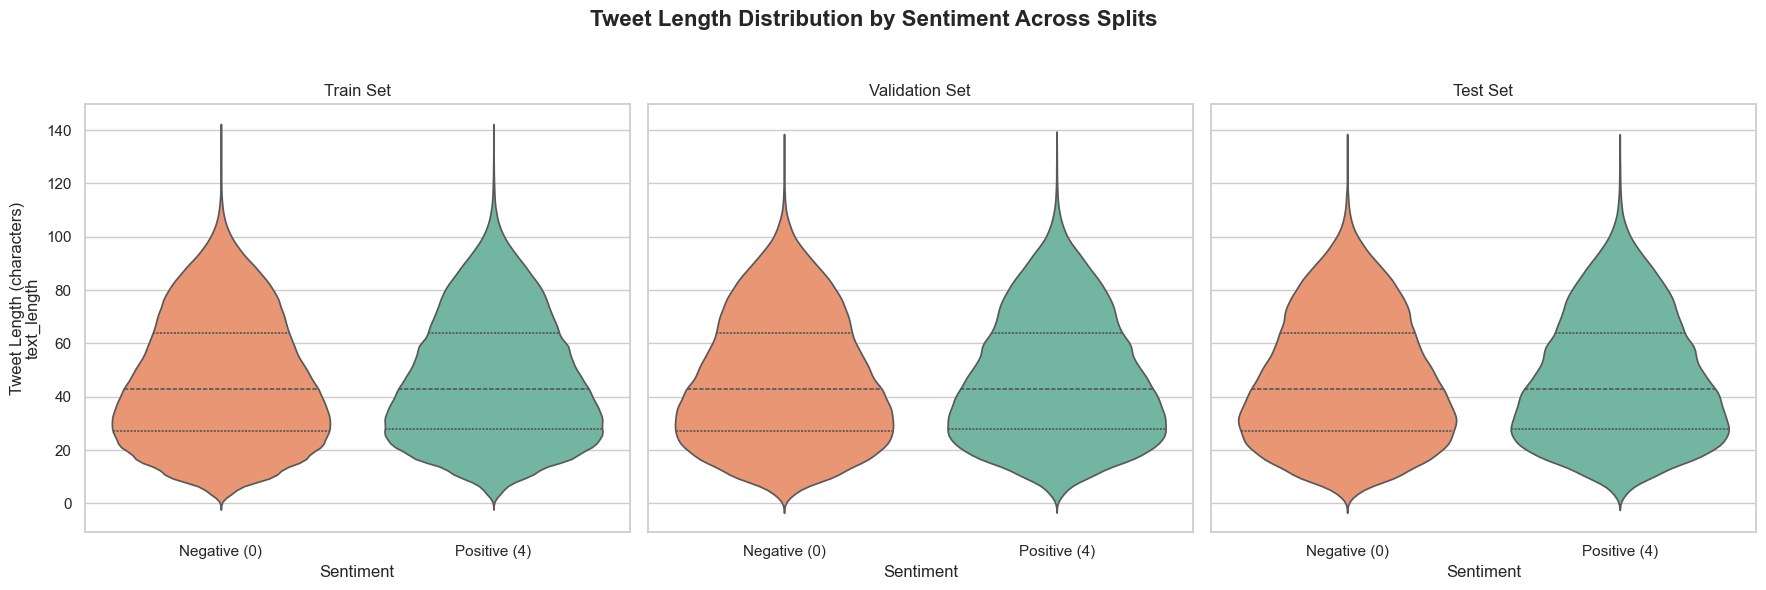

In [29]:
# here we validate the distributions are identical and intact

# Combine text + label for plotting, and calculate text length
train_plot_df = pd.concat([X_train, y_train], axis=1).copy()
val_plot_df = pd.concat([X_val, y_val], axis=1).copy()
test_plot_df = pd.concat([X_test, y_test], axis=1).copy()

# Ensure text_length column is present
train_plot_df['text_length'] = train_plot_df['text'].str.len()
val_plot_df['text_length'] = val_plot_df['text'].str.len()
test_plot_df['text_length'] = test_plot_df['text'].str.len()

# Ensure 'target' is integer (not string) for palette mapping
train_plot_df['target'] = train_plot_df['target'].astype(int)
val_plot_df['target'] = val_plot_df['target'].astype(int)
test_plot_df['target'] = test_plot_df['target'].astype(int)

# Set up subplot layout
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot train
sns.violinplot(ax=axes[0], data=train_plot_df, x='target', y='text_length', hue='target', palette=sentiment_palette, inner='quartile', legend=False)
axes[0].set_title('Train Set')
axes[0].set_xlabel('Sentiment')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Negative (0)', 'Positive (4)'])

# Plot validation
sns.violinplot(ax=axes[1], data=val_plot_df, x='target', y='text_length', hue='target', palette=sentiment_palette, inner='quartile', legend=False)
axes[1].set_title('Validation Set')
axes[1].set_xlabel('Sentiment')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Negative (0)', 'Positive (4)'])

# Plot test
sns.violinplot(ax=axes[2], data=test_plot_df, x='target', y='text_length', hue='target', palette=sentiment_palette, inner='quartile', legend=False)
axes[2].set_title('Test Set')
axes[2].set_xlabel('Sentiment')
axes[2].set_xticks([0, 1])
axes[2].set_xticklabels(['Negative (0)', 'Positive (4)'])

# Shared Y-label and layout
fig.supylabel('Tweet Length (characters)', fontsize=12)
plt.suptitle("Tweet Length Distribution by Sentiment Across Splits", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#### Observation: Split Integrity Confirmed

The violin plots and data checks confirm that our training, validation, and test sets are:
- **Balanced in sentiment labels** (positive and negative)
- **Representative of tweet length distributions**

This validates the effectiveness of our stratified sampling approach and gives us confidence that each split is suitable for its intended role in model development and evaluation.

### Saving Splitted Prepared Datasets

To ensure consistency and avoid data leakage, we save the final splits (training, validation, and test sets) as separate CSV files. This allows all team members and downstream scripts to work with the exact same dataset splits during model training and evaluation.

#### What is Data Leakage and Why We Avoid It

In our case, **data leakage** refers to the unintentional use of information from the test set during model training or validation. This could happen, for example, if we:
- Use the test set while tuning hyperparameters
- Generate features (e.g., TF-IDF scores) using the entire dataset before splitting

Such leakage would give the model unfair insight into unseen data, resulting in **inflated validation performance** and poor real-world generalization.

To prevent this:
- We split the dataset into training, validation, and test sets **before any modeling or feature extraction**
- We save these splits as separate files to ensure consistent use across all experiments

In [30]:
# Finally, we save splits as CSV to ensure no data leakage takes place as differnt team members split and train the models. this way everyone uses the same training dataset.

import zipfile

# Set this to True if running in Google Colab
USE_COLAB = False

# File paths
train_path = os.path.join(processed_data_dir, "train_dataset.csv")
val_path = os.path.join(processed_data_dir, "val_dataset.csv")
test_path = os.path.join(processed_data_dir, "test_dataset.csv")

# Save split datasets
train_df.to_csv(train_path, index=False)
val_df.to_csv(val_path, index=False)
test_df.to_csv(test_path, index=False)
print("Local files saved.")

# Optional: Save as zip archive
if USE_COLAB:
    zip_path = os.path.join(processed_data_dir, "sentiment140_splits.zip")
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        zipf.write(train_path, arcname="train_dataset.csv")
        zipf.write(val_path, arcname="val_dataset.csv")
        zipf.write(test_path, arcname="test_dataset.csv")

    print(f"✅ Datasets saved to: {processed_data_dir}")
    print(f"📦 Zipped archive saved to: {zip_path}")

# Optional: download in Colab
if USE_COLAB:
    try:
        from google.colab import files
        files.download(train_path)
        files.download(val_path)
        files.download(test_path)
        files.download(zip_path)
    except ImportError:
        print("Google Colab download skipped — not running in Colab.")

    print("\n📦 Ready to commit the archive to your GitHub repository:")
    print(f"cd to repo folder and run:\n")
    print(f"git add {zip_path}")
    print(f'git commit -m "Add compressed dataset splits for reproducibility"')
    print("git push")

Local files saved.


### Future Enhancements for Data Preprocessing (Optional)

While our current preprocessing pipeline is sufficient for training both classical and deep learning models on Twitter data, there are a few **optional enhancements** that could further improve model performance or robustness in future iterations:

#### Emoji Handling
- Emojis can carry strong sentiment (e.g., 😡, 😂, ❤️), especially in short-form text like tweets.
- Our current pipeline removes them entirely. Future improvements could:
  - Map common emojis to sentiment-relevant tokens (e.g., 😂 → "laugh", 😡 → "angry")
  - Or explicitly remove and log them to maintain consistency.

#### Hashtag Normalization
- Hashtags often signal opinion or emotion (e.g., `#blessed`, `#fail`, `#loveit`).
- In this version, hashtags are removed with punctuation.
- A possible enhancement:
  - Preserve hashtags during cleaning
  - Use a segmentation tool (e.g., `wordsegment`) to split compound hashtags (`#stayhome` → "stay home")

#### Contraction Expansion
- Contractions like "can't", "I'm", "won't" may confuse tokenizers or obscure negation.
- Expanding them to full forms ("can not", "I am", "will not") can:
  - Improve clarity for models like Logistic Regression and LSTM
  - Simplify downstream text processing

#### Slang & Abbreviation Normalization
- Tweets often include informal language: `"u"`, `"idk"`, `"smh"`, `"omg"`, etc.
- Expanding or standardizing these could help models generalize better.
- This can be done using curated slang dictionaries (e.g., `noslang`) or Twitter-specific token libraries.

These enhancements are not critical for the current milestone, but would be useful if the goal shifts toward production-grade sentiment systems or cross-domain generalization.


## Notebook Summary & Next Steps

In this notebook, we:
- Loaded and cleaned the Sentiment140 dataset
- Applied a comprehensive preprocessing pipeline
- Stratified the data by both sentiment and tweet length
- Created consistent train/validation/test splits for reproducible experiments

In the next stage of our project, we will begin **model development**, where we compare multiple classifiers using the training and validation sets. The **test set will be reserved exclusively for final performance evaluation** after model selection is complete.
